In [15]:
import torch
from torch_geometric.data import Data
import pandas as pd
import pickle
import numpy as np

from torch_geometric.nn import SAGEConv
import torch
import torch_geometric
import torch.nn.functional as F

# Helper Functions

In [4]:
def read_data(nodes_df_path, edges_df_path, subject_mapping_path):
    nodes_df = pd.read_csv(nodes_df_path)
    edges_df = pd.read_csv(edges_df_path)
    with open(subject_mapping_path, 'rb') as f:
        subject_mapping = pickle.load(f)
    return nodes_df, edges_df, subject_mapping

def get_node_id_mapping(nodes_df):
    node_id_mapping, inverse_node_id_mapping = dict(), dict()
    for i, node_id in enumerate(nodes_df['nodeId']):
        node_id_mapping[i] = node_id
        inverse_node_id_mapping[node_id] = i
    return node_id_mapping, inverse_node_id_mapping

In [5]:
def get_feature_vectors(nodes_df):
    # TODO: Complete this function
    feature_list = []
    for i, feature in enumerate(nodes_df['features']):
        feature = list(map(int, feature[1:-1].split(','))) # turn string into list of numbers
        feature_list.append(torch.tensor(feature, dtype=torch.float32))
    return torch.stack(feature_list)

def get_edges(edges_df, inverse_node_id_mapping):
    # TODO: Complete this function
    edges_list = []
    for i, edge in enumerate(edges_df.to_dict('records')):
        source_node = inverse_node_id_mapping[edge['sourceNodeId']]
        target_node = inverse_node_id_mapping[edge['targetNodeId']]
        # relation = edge['relationshipType'] ### the relation is always CITES
        edges_list.append(torch.tensor([source_node, target_node], dtype=torch.long))
    return torch.stack(edges_list).t().contiguous()

def get_labels(nodes_df, subject_mapping):
    # TODO: Complete this function
    return torch.tensor([subject_mapping[val] for val in nodes_df['subject'].values], dtype=torch.long)

# Graph Generation

In [6]:
nodes_df_path = 'data/nodes.csv'
edges_df_path = 'data/edges.csv'
subject_mapping_path = 'data/subject_mapping.pkl'
nodes_df, edges_df, subject_mapping = read_data(nodes_df_path, edges_df_path, subject_mapping_path)

In [7]:
# Check data sizes:
print("Number of nodes:", nodes_df.shape[0])
print("Dimension of features:", len(nodes_df['features'].iloc[0].split(',')))
print("Number of edges:", edges_df.shape[0])
print("Number of labels:", len(subject_mapping))
print(subject_mapping)

Number of nodes: 2708
Dimension of features: 1433
Number of edges: 10556
Number of labels: 7
{'Neural_Networks': 0, 'Rule_Learning': 1, 'Reinforcement_Learning': 2, 'Probabilistic_Methods': 3, 'Theory': 4, 'Genetic_Algorithms': 5, 'Case_Based': 6}


In [8]:
node_id_mapping, inverse_node_id_mapping = get_node_id_mapping(nodes_df)

# TODO: These functions need to be implemented. You can decide what are the arguments to these functions.
x = get_feature_vectors(nodes_df)
print("x:", x.shape)

edge_index = get_edges(edges_df, inverse_node_id_mapping)
print("edge_index:", edge_index.shape)

y = get_labels(nodes_df, subject_mapping)
print("y:", y.shape)

x: torch.Size([2708, 1433])
edge_index: torch.Size([2, 10556])
y: torch.Size([2708])


In [9]:
with open('data/indices_dict_part2.pkl', 'rb') as f:
    indices_dict = pickle.load(f)

In [10]:
train_mask = torch.tensor([1 if node_id_mapping[i] in indices_dict['train_indices'] else 0 for i in range(x.shape[0])], dtype=torch.bool)
valid_mask = torch.tensor([1 if node_id_mapping[i] in indices_dict['valid_indices'] else 0 for i in range(x.shape[0])], dtype=torch.bool)
test_mask = torch.tensor([1 if node_id_mapping[i] in indices_dict['test_indices'] else 0 for i in range(x.shape[0])], dtype=torch.bool)

In [11]:
data = Data(x=x, y=y, edge_index=edge_index, train_mask=train_mask, valid_mask=valid_mask, test_mask=test_mask)
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], valid_mask=[2708], test_mask=[2708])

# GNN Model

In [12]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [16]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels, output_dim, seed=1):
        super().__init__()
        torch.cuda.manual_seed(seed)
        self.conv1 = SAGEConv((-1, -1), hidden_channels, normalize=True)
        self.conv2 = SAGEConv((-1, -1), hidden_channels//2, normalize=True)
        self.conv3 = SAGEConv((-1, -1), output_dim, normalize=True)

    def forward(self, x, edge_index):
        # TODO: Complete this function
        x = self.conv1(x, edge_index)
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.leaky_relu(x)
        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=0.5, training=self.training)
        # x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Training

In [25]:
output_dim = len(subject_mapping)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(x.shape[1], output_dim).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-3)
max_epochs = 1000
delta_bound = 0.05

In [26]:
def early_stop(rel_data_mask):
    """ Compute accuracy on the validation set to check for necessary early stopping """
    model.eval()
    preds = model(data.x, data.edge_index).argmax(dim=1)
    correct = (preds[rel_data_mask] == data.y[rel_data_mask]).sum()
    acc = int(correct) / int(rel_data_mask.sum())
    return acc

In [30]:
def train():
    # TODO: Complete this function
    model.train()
    optimizer.zero_grad()
    avg_loss = 0
    prev_val_acc = 0
    
    # train for at most max_epochs:
    for epoch in range(1, max_epochs + 1):
        # training step:
        loss = F.nll_loss(model(data.x, data.edge_index)[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        
        # occasional output and check:
        if epoch % 5 == 0:
            val_acc = early_stop(valid_mask)
            print('Epoch: {:2d}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch, avg_loss / 10, val_acc))
            avg_loss = 0

            # early stopping (if results are getting worse by at least delta_bound):
            if prev_val_acc > val_acc + delta_bound:
                break
            prev_val_acc = val_acc

In [31]:
train()

Epoch:  5, Loss: 3.0778, Accuracy: 0.6619
Epoch: 10, Loss: 3.0682, Accuracy: 0.6639
Epoch: 15, Loss: 3.0458, Accuracy: 0.6721
Epoch: 20, Loss: 3.0178, Accuracy: 0.7008
Epoch: 25, Loss: 3.0210, Accuracy: 0.7213
Epoch: 30, Loss: 3.0563, Accuracy: 0.7377
Epoch: 35, Loss: 3.0869, Accuracy: 0.7418
Epoch: 40, Loss: 3.1025, Accuracy: 0.7398
Epoch: 45, Loss: 3.1052, Accuracy: 0.7357
Epoch: 50, Loss: 3.0959, Accuracy: 0.7336
Epoch: 55, Loss: 3.0728, Accuracy: 0.7254
Epoch: 60, Loss: 3.0343, Accuracy: 0.7131
Epoch: 65, Loss: 3.0011, Accuracy: 0.7029
Epoch: 70, Loss: 3.0260, Accuracy: 0.7008
Epoch: 75, Loss: 3.0752, Accuracy: 0.7152
Epoch: 80, Loss: 3.0976, Accuracy: 0.7377
Epoch: 85, Loss: 3.0955, Accuracy: 0.7439
Epoch: 90, Loss: 3.0772, Accuracy: 0.7398
Epoch: 95, Loss: 3.0496, Accuracy: 0.7398
Epoch: 100, Loss: 3.0272, Accuracy: 0.7357
Epoch: 105, Loss: 3.0236, Accuracy: 0.7398
Epoch: 110, Loss: 3.0292, Accuracy: 0.7398
Epoch: 115, Loss: 3.0341, Accuracy: 0.7398
Epoch: 120, Loss: 3.0423, Accu

Note that we are 'overtraining' in this running case, since 1000 epochs is more than enough and 500 would be a good number to stop at. However, in some runs, when the initial weights are not good, the model might not converge to a good solution in 500 epochs and take much longer to learn.

A larger learning rate might help in this case, but significantly ruins the performance afterwards when better accuracies are reached. We also use an early check on the validation set to try and avoid overfitting as much as possible.

After trying our some combinations of epochs, learning rate, weights and early stopping, this is the best combination we could find.

# Evaluation

In [23]:
def evaluate(rel_data_mask):
    model.eval()
    preds = model(data.x, data.edge_index).argmax(dim=1)
    correct = (preds[rel_data_mask] == data.y[rel_data_mask]).sum()
    acc = int(correct) / int(rel_data_mask.sum())
    print(f'Accuracy: {acc:.4f}')

In [32]:
evaluate(data.test_mask)

Accuracy: 0.8241


# TSNE Visualization

In [33]:
# TODO: Complete this function
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize():
    tnse = TSNE(n_components=2)
    x_embedded = tnse.fit_transform(data.x.cpu().detach().numpy())
    plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=data.y.cpu().numpy())
    plt.show()

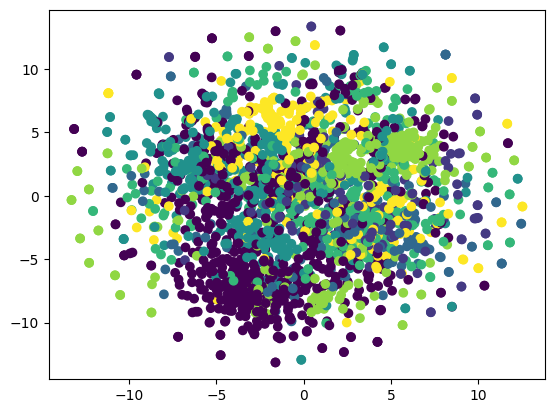

In [34]:
visualize()